In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
df = pd.read_csv('../data/from_pyupbit/ethereum.csv')

In [4]:
df

,timestamp,open,high,low,close,volume,value
0,2018-08-08 02:52:00,467000.0,467950.0,467000.0,467950.0,1.196250,5.586499e+05
1,2018-08-08 02:53:00,467000.0,467000.0,467000.0,467000.0,0.005000,2.335000e+03
2,2018-08-08 02:55:00,467000.0,467000.0,467000.0,467000.0,1.531450,7.151872e+05
3,2018-08-08 02:58:00,467950.0,468000.0,467950.0,468000.0,12.286460,5.750010e+06
4,2018-08-08 02:59:00,467700.0,467700.0,467700.0,467700.0,0.072733,3.401707e+04
...,...,...,...,...,...,...,...
3125995,2024-10-11 03:40:00,3211000.0,3211000.0,3209000.0,3210000.0,10.330143,3.314964e+07
3125996,2024-10-11 03:41:00,3210000.0,3210000.0,3207000.0,3209000.0,1.834767,5.888273e+06
3125997,2024-10-11 03:42:00,3207000.0,3209000.0,3207000.0,3209000.0,13.585955,4.359702e+07
3125998,2024-10-11 03:43:00,3211000.0,3211000.0,3206000.0,3208000.0,20.042243,6.435423e+07


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
joblib.dump(scaler, 'models/ethereum_scaler.pkl')

['models/ethereum_scaler.pkl']

In [7]:
timestep = 1

In [8]:
X = []
y = []
for i in range(len(scaled_data) - timestep - 1):
    X.append(scaled_data[i:(i + timestep), 0])
    y.append(scaled_data[i + timestep, 0])

In [9]:
X, y = np.array(X), np.array(y)

In [10]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [11]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:len(X)]

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [16]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
78150/78150 [==============================] - 155s 2ms/step - loss: 4.8112e-05 - val_loss: 2.9452e-06
Epoch 2/20
78150/78150 [==============================] - 152s 2ms/step - loss: 9.7563e-07 - val_loss: 1.1621e-06
Epoch 3/20
78150/78150 [==============================] - 157s 2ms/step - loss: 7.9419e-07 - val_loss: 4.2963e-07
Epoch 4/20
78150/78150 [==============================] - 156s 2ms/step - loss: 6.9681e-07 - val_loss: 4.6706e-07
Epoch 5/20
78150/78150 [==============================] - 148s 2ms/step - loss: 6.4866e-07 - val_loss: 3.5845e-07
Epoch 6/20
78150/78150 [==============================] - 144s 2ms/step - loss: 6.2651e-07 - val_loss: 1.2476e-06
Epoch 7/20
78150/78150 [==============================] - 148s 2ms/step - loss: 6.1161e-07 - val_loss: 1.5871e-06
Epoch 8/20
78150/78150 [==============================] - 148s 2ms/step - loss: 5.6925e-07 - val_loss: 5.0974e-07
Epoch 9/20
78150/78150 [==============================] - 144s 2ms/step - loss: 5.5663e-

In [17]:
model.save('models/lstm_ethereum.h5')

/Users/sun/anaconda3/envs/dl/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

19538/19538 [==============================] - 12s 610us/step


In [19]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [20]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 2951.08
Test RMSE: 3334.06


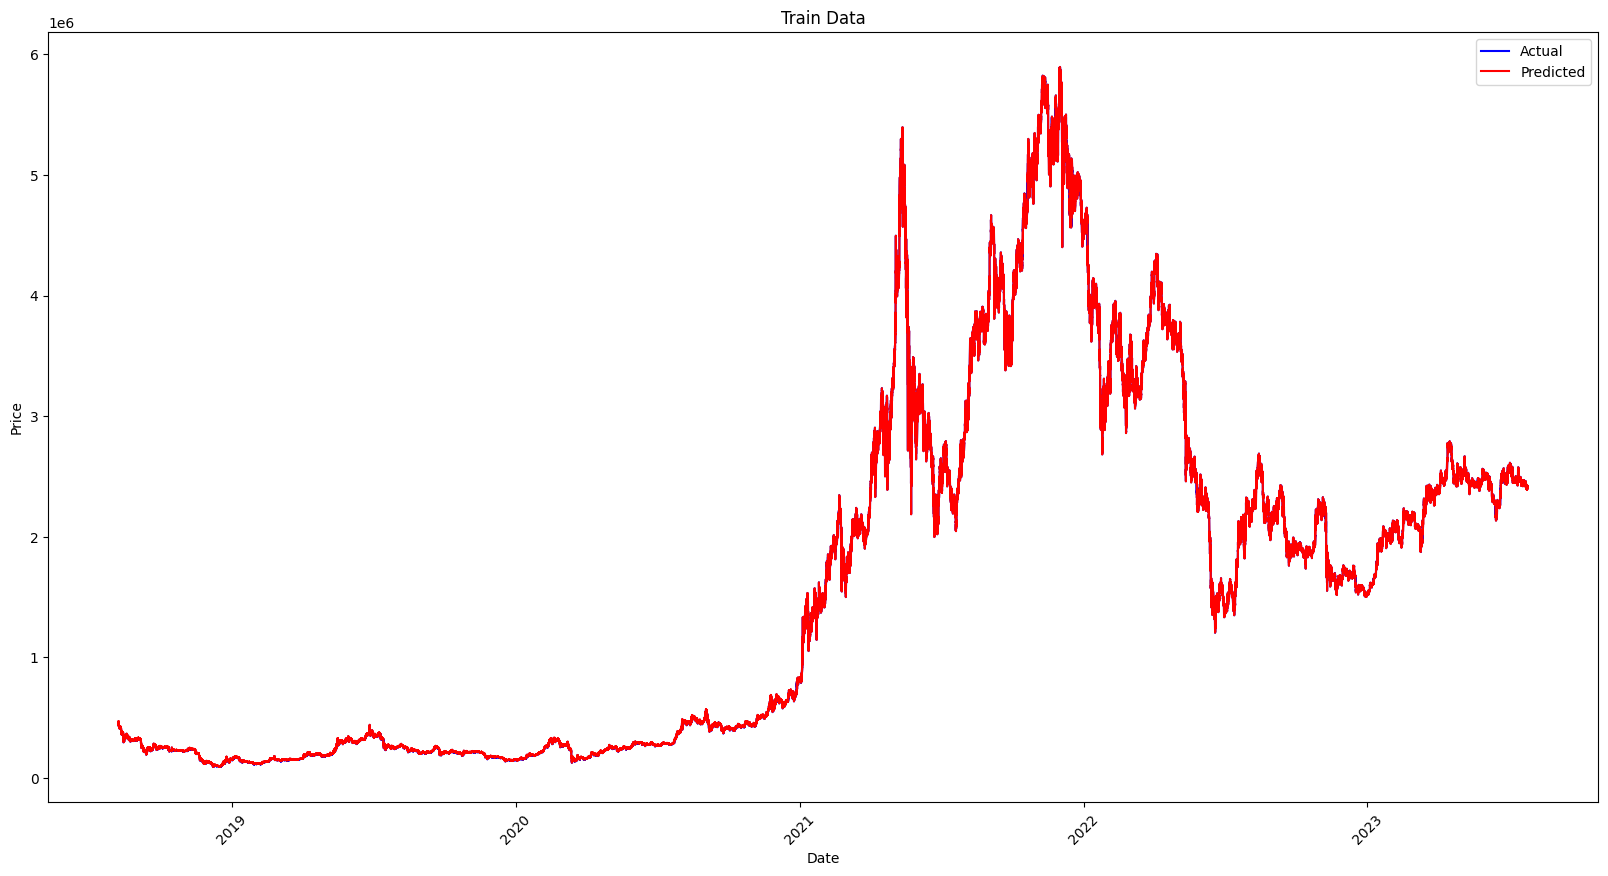

In [21]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

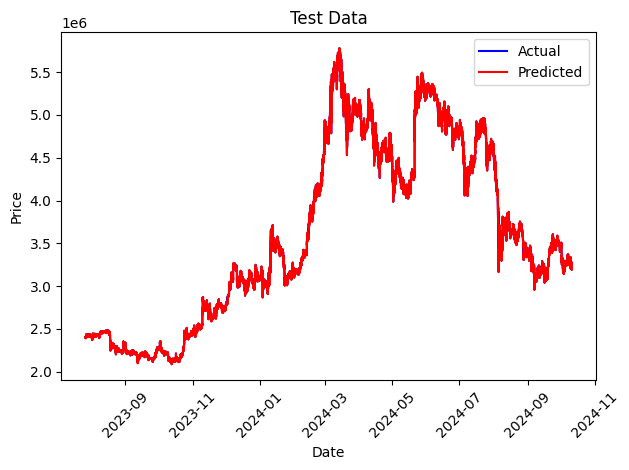

In [22]:
plt.subplot(1, 1, 1)
plt.plot(test_dates, y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates, test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [52]:
last_1_day = scaled_data[-timestep:]
X_predict = last_1_day.reshape(1, timestep, 1)
print(scaler.inverse_transform(last_1_day))

[[3204000.]]


In [47]:
preds = []
for i in range(30):  # 30분 예측
    pred = model.predict(X_predict)
    preds.append(pred[0][0])
    pred = pred.reshape(1, 1, 1)
    X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)

1/1 [==============================] - 0s 16ms/step


In [50]:
preds = scaler.inverse_transform([preds])

In [51]:
preds

array([[3203051.56249165, 3202103.56642783, 3201155.91622174,
        3200208.26601565, 3199260.9616673 , 3198314.00317669,
        3197367.39054382, 3196420.77791095, 3195474.51113582,
        3194528.59021842, 3193582.66930103, 3192637.09424138,
        3191691.51918173, 3190745.94412208, 3189801.0607779 ,
        3188856.52329147, 3187911.98580503, 3186967.79417634,
        3186023.94840538, 3185080.10263443, 3184136.60272121,
        3183193.102808  , 3182249.94875252, 3181306.79469705,
        3180363.98649931, 3179421.17830157, 3178478.71596158,
        3177536.94533706, 3176595.17471254, 3175653.40408802]])

In [22]:
# Predict the future
# future_predictions = []
# for _ in range(len(new_df)):
#     pred = model.predict(X_predict)
#     future_predictions.append(pred[0, 0])
#     pred = pred.reshape(1, 1, 1)
#     X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))